# Preprocessing audio data


### Remove background noise with signal processing tools

Environmental audio recordings usually have stationary noise that needs to be removed to
enhance the signal to noise ratio of biological sounds.
This example shows different ways to remove stationary background noise using spectral 
subtraction techniques. These techniques are applied over the spectrogram and return a 2D matrix. 

In [1]:
import numpy as np
import librosa
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

import maad
from maad.util import plot2d, power2dB

import warnings
warnings.filterwarnings("ignore")

### Load and plot the spectrogram of the original audio file

First, we load the audio file and take its spectrogram.
The linear spectrogram is then transformed into dB. The dB range is  96dB 
which is the maximum dB range value for a 16bits audio recording. We add
96dB in order to get have only positive values in the spectrogram.



Original sharpness : 3.962


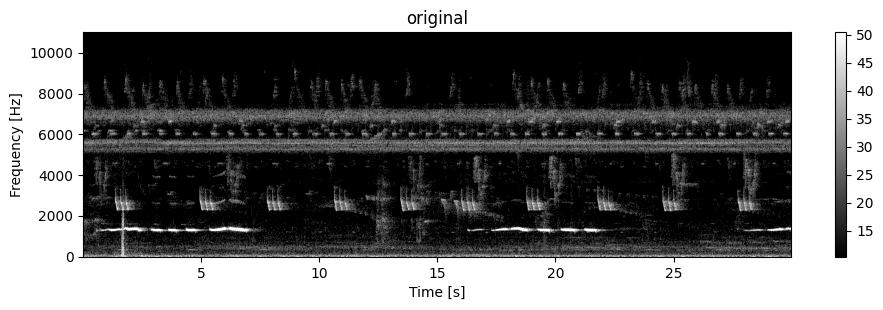

In [2]:
s, fs = librosa.load('tinamou.mp3', sr=22050, duration=30)
Sxx, tn, fn, ext = maad.sound.spectrogram(s, fs, fcrop=[0,20000], tcrop=[0,60])
Sxx_dB = power2dB(Sxx, db_range=96) + 96

print ("Original sharpness : %2.3f" %maad.sound.sharpness(Sxx_dB))
plot2d(Sxx_dB, extent=ext, title='original', vmin=np.median(Sxx_dB), vmax=np.median(Sxx_dB)+40);

### Test different methods of the [scikit-maad](https://scikit-maad.github.io/) package to remove background noise
We use the sharpness metric to have a quantitative estimation of how well is the noise 
reduction. For a more comprehensive analysis, other metrics should be use in complement.

`remove_background`

Duration 0.052 s
Sharpness : 2.944


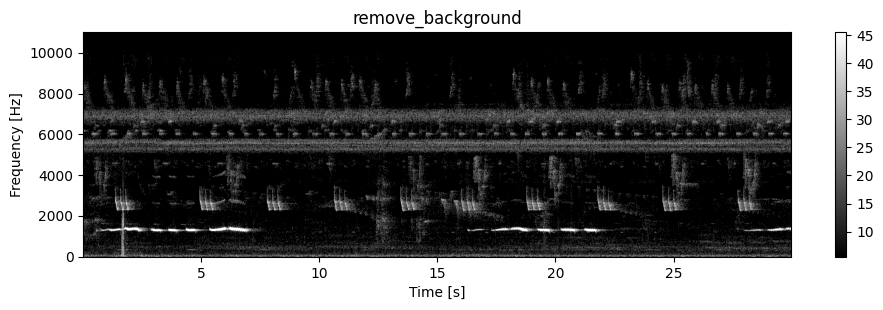

In [3]:
start = timer()
X1, noise_profile1, _ = maad.sound.remove_background(Sxx_dB)
elapsed_time = timer() - start

print("Duration %2.3f s" %elapsed_time)
print ("Sharpness : %2.3f" %maad.sound.sharpness(X1))
plot2d(X1, extent=ext, title='remove_background', vmin=np.median(X1), vmax=np.median(X1)+40);

`median_equalizer`

Duration 0.042 s
Sharpness : 1.762


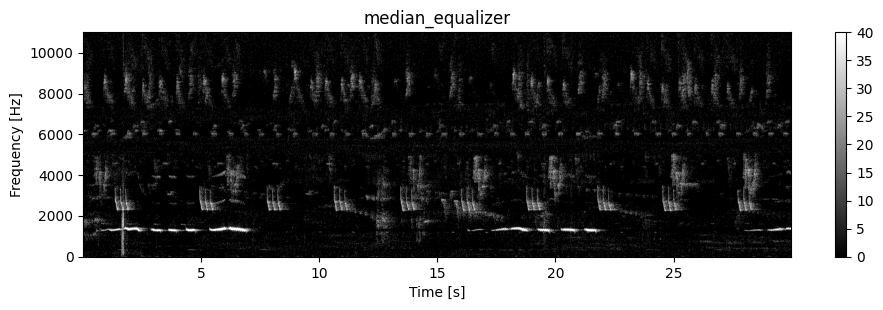

In [4]:
start = timer()
X2 = maad.sound.median_equalizer(Sxx)
X2 = power2dB(X2)
elapsed_time = timer() - start

print("Duration %2.3f s" %elapsed_time)
print ("Sharpness : %2.3f" %maad.sound.sharpness(X2))
plot2d(X2,extent=ext, title='median_equalizer', vmin=np.median(X2), vmax=np.median(X2)+40);

`remove_background_morpho`

Duration 0.402 s
Sharpness : 1.635


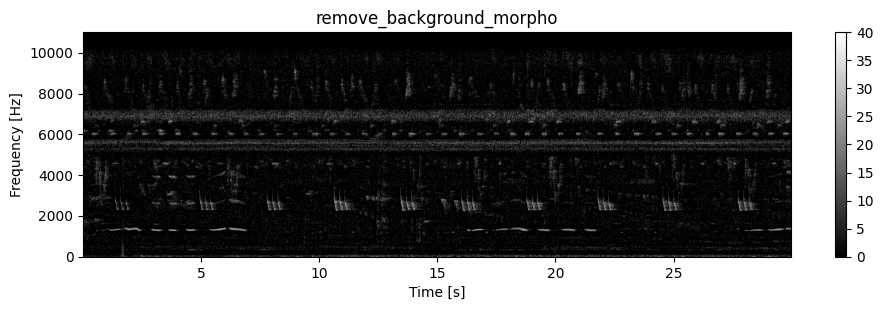

In [5]:
start = timer()
X3, noise_profile3,_ = maad.sound.remove_background_morpho(Sxx_dB, q=0.95) 
elapsed_time = timer() - start

print("Duration %2.3f s" %elapsed_time)
print ("Sharpness : %2.3f" %maad.sound.sharpness(X3))
plot2d(X3, extent=ext, title='remove_background_morpho', vmin=np.median(X3), vmax=np.median(X3)+40);

`remove_background_along_axis`

Duration 0.018 s
Sharpness : 2.017


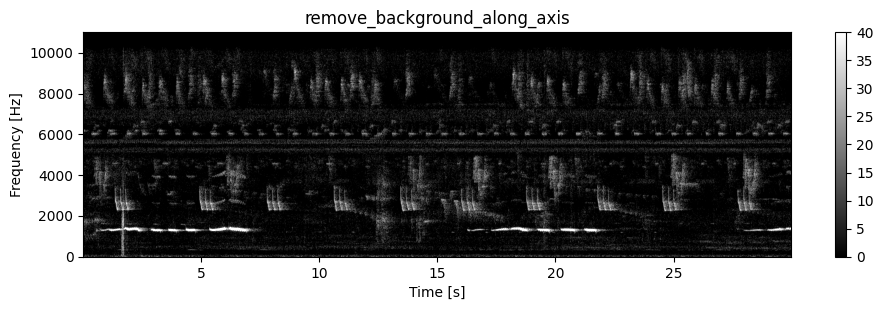

In [6]:
start = timer()
X4, noise_profile4 = maad.sound.remove_background_along_axis(Sxx_dB, mode='median', axis=1) 
elapsed_time = timer() - start

print("Duration %2.3f s" %elapsed_time)
print ("Sharpness : %2.3f" %maad.sound.sharpness(X4))
plot2d(X4, extent=ext, title='remove_background_along_axis', vmin=np.median(X4), vmax=np.median(X4)+40);

### Test different methods of the [librosa](https://librosa.org/doc/latest/index.html) package to remove background noise
`librosa.decompose.hpss`

Duration 0.811 s
Sharpness : 2.311


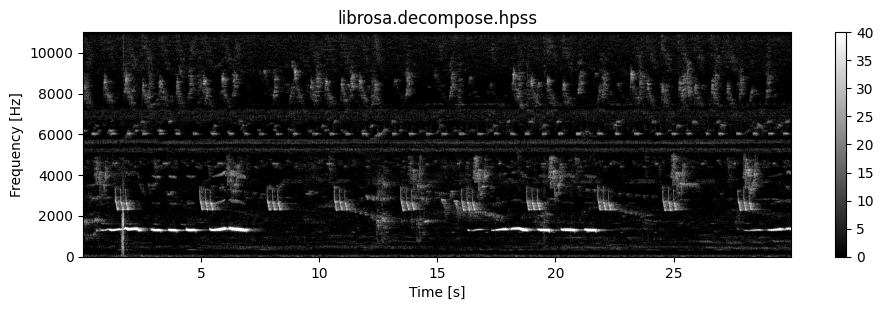

In [7]:
start = timer()
H, P = librosa.decompose.hpss(Sxx, kernel_size=(11,51), power=2.0, margin=(1.0,5.0))
X5 = power2dB(H+P)
X5, _ = maad.sound.remove_background_along_axis(X5, mode='median', axis=1)
elapsed_time = timer() - start

print("Duration %2.3f s" %elapsed_time)
print ("Sharpness : %2.3f" %maad.sound.sharpness(X5))
plot2d(X5, extent=ext, title='librosa.decompose.hpss', vmin=np.median(X5), vmax=np.median(X5)+40);

`librosa.decompose.nn_filter`

Duration 3.260 s
Sharpness : 0.643


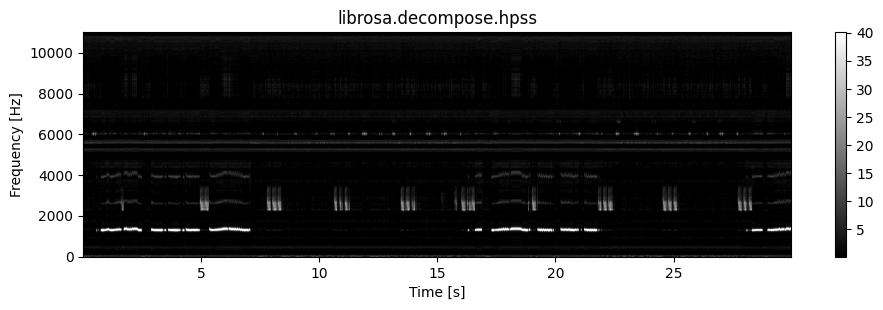

In [8]:
start = timer()
X6 = librosa.decompose.nn_filter(Sxx, aggregate=np.median, metric='cosine')
X6 = power2dB(X6)
X6, _ = maad.sound.remove_background_along_axis(X6, mode='median', axis=1)
elapsed_time = timer() - start

print("Duration %2.3f s" %elapsed_time)
print ("Sharpness : %2.3f" %maad.sound.sharpness(X6))
plot2d(X6, extent=ext, title='librosa.decompose.hpss', vmin=np.median(X6), vmax=np.median(X6)+40);

### Evaluate preprocessing using a feature extractor (ResNet18) pre-trained on the ImageNet database

In [9]:
from dataset.darksound import Darksound
from dataset.sampler import TaskSampler
from trainer import trainer

from torch import nn
from torch.optim import Adam

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models.feature_extraction import create_feature_extractor

from networks.matchnet import MatchingNetworks
from networks.protonet import PrototypicalNetworks
from networks.relatnet import RelationNetworks

In [10]:
# Preprocess the spectrogram with ResNet18 transform
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
print(weights.transforms())

# Load test set
test_set = Darksound(split='test', tfr='mel', transform=transforms.Compose([weights.transforms()]))

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### Create a few-shot classification task using the `TaskSampler` method

In [11]:
N_WAY = 5  # Number of classes in a task
K_SHOT = 5  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_EVALUATION_TASKS = 500

# Few-Shot Classification task
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=K_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episode,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


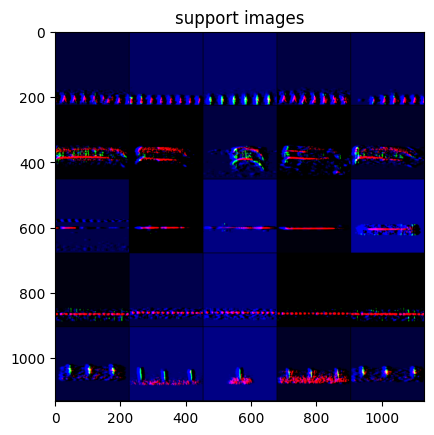

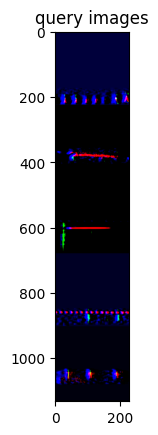

In [12]:
def plot_images(images, title, images_per_row):
    plt.figure()
    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))
    
(support_images, support_labels, query_images, query_labels, class_ids) = next(iter(test_loader))
plot_images(support_images, "support images", images_per_row=K_SHOT)
plot_images(query_images, "query images", images_per_row=N_QUERY)

### Automating the evaluation of three commonly used Few-Shot Learning (FSL) algorithms

In [15]:
def evaluation(model, tfr='cqt', remove_background=False, hpss=False):
    # Load the dataset
    test_set = Darksound(split='test',
                         tfr=tfr,
                         remove_background=remove_background, 
                         hpss=hpss, 
                         transform=transforms.Compose([weights.transforms()]))
    # Create the few-shot tasks
    test_sampler = TaskSampler(test_set, 
                               n_way=N_WAY, 
                               n_shot=K_SHOT, 
                               n_query=N_QUERY, 
                               n_tasks=N_EVALUATION_TASKS)
    # Load the data
    test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=0,
        pin_memory=True,
        collate_fn=test_sampler.episode)
    
    # Load the pre-trained model 
    convolutional_network = torchvision.models.resnet18(pretrained=True)
    convolutional_network.fc = nn.Flatten()
    
    if model == 'MATCHING':
        model = MatchingNetworks(convolutional_network, use_softmax=True)
    if model == 'PROTOTYPICAL':
        model = PrototypicalNetworks(convolutional_network, use_softmax=True)
    if model == 'RELATION':
        convolutional_network = create_feature_extractor(convolutional_network, return_nodes=['layer2.0.conv1']) 
        model = RelationNetworks(convolutional_network, use_softmax=True)
        
    # Evaluate the model  
    trainer(model, test_loader, optimizer, criterion, train=False, verbose=True)

        
models = ['MATCHING', 'PROTOTYPICAL', 'RELATION']

for model in models:
    print(f'EVALUATING THE {model} NETWORK\n')
    for i in range(2):
        if i == 0:
            print('remove_background=False, hpss=False')
            evaluation(model, remove_background=False, hpss=False)
        if i == 1:
            print('remove_background=False, hpss=True')
            evaluation(model, remove_background=False, hpss=True)
#         if i == 2:
#             print('remove_background=True, hpss=False')
#             evaluation(model, remove_background=True, hpss=False)
#         if i == 3:
#             print('remove_background=True, hpss=True')
#             evaluation(model, remove_background=True, hpss=True)
    print('******************************************************************************\n')

EVALUATING THE MATCHING NETWORK

remove_background=False, hpss=False


Evaluating: 100%|████████████████████████████████████████████████████| 500/500 [33:58<00:00,  4.08s/it, accuracy=0.712]


              precision    recall  f1-score   support

           0      0.697     0.602     0.646       500
           1      0.694     0.740     0.716       500
           2      0.706     0.774     0.739       500
           3      0.741     0.740     0.741       500
           4      0.721     0.704     0.713       500

    accuracy                          0.712      2500
   macro avg      0.712     0.712     0.711      2500
weighted avg      0.712     0.712     0.711      2500

remove_background=False, hpss=True


Evaluating: 100%|████████████████████████████████████████████████████| 500/500 [35:17<00:00,  4.24s/it, accuracy=0.792]


              precision    recall  f1-score   support

           0      0.792     0.708     0.748       500
           1      0.757     0.802     0.779       500
           2      0.775     0.866     0.818       500
           3      0.787     0.834     0.810       500
           4      0.862     0.748     0.801       500

    accuracy                          0.792      2500
   macro avg      0.794     0.792     0.791      2500
weighted avg      0.794     0.792     0.791      2500

******************************************************************************

EVALUATING THE PROTOTYPICAL NETWORK

remove_background=False, hpss=False


Evaluating: 100%|████████████████████████████████████████████████████| 500/500 [30:47<00:00,  3.69s/it, accuracy=0.614]


              precision    recall  f1-score   support

           0      0.619     0.576     0.597       500
           1      0.609     0.678     0.641       500
           2      0.613     0.658     0.635       500
           3      0.636     0.560     0.596       500
           4      0.599     0.600     0.599       500

    accuracy                          0.614      2500
   macro avg      0.615     0.614     0.614      2500
weighted avg      0.615     0.614     0.614      2500

remove_background=False, hpss=True


Evaluating: 100%|████████████████████████████████████████████████████| 500/500 [40:37<00:00,  4.87s/it, accuracy=0.772]


              precision    recall  f1-score   support

           0      0.736     0.726     0.731       500
           1      0.731     0.772     0.751       500
           2      0.793     0.842     0.817       500
           3      0.795     0.824     0.809       500
           4      0.812     0.698     0.751       500

    accuracy                          0.772      2500
   macro avg      0.773     0.772     0.772      2500
weighted avg      0.773     0.772     0.772      2500

******************************************************************************

EVALUATING THE RELATION NETWORK

remove_background=False, hpss=False


Evaluating: 100%|████████████████████████████████████████████████████| 500/500 [34:13<00:00,  4.11s/it, accuracy=0.201]


              precision    recall  f1-score   support

           0      0.332     0.140     0.197       500
           1      0.227     0.140     0.173       500
           2      0.173     0.206     0.188       500
           3      0.175     0.280     0.215       500
           4      0.206     0.240     0.222       500

    accuracy                          0.201      2500
   macro avg      0.222     0.201     0.199      2500
weighted avg      0.222     0.201     0.199      2500

remove_background=False, hpss=True


Evaluating: 100%|████████████████████████████████████████████████████| 500/500 [37:12<00:00,  4.47s/it, accuracy=0.206]

              precision    recall  f1-score   support

           0      0.299     0.256     0.276       500
           1      0.236     0.212     0.223       500
           2      0.194     0.226     0.209       500
           3      0.157     0.200     0.176       500
           4      0.165     0.134     0.148       500

    accuracy                          0.206      2500
   macro avg      0.210     0.206     0.206      2500
weighted avg      0.210     0.206     0.206      2500

******************************************************************************



### Results on 100 episodic tasks

**Semitone scale (CQT)**

| Network | Remove Background  | HPSS  | Results |
|---|---|---|---|
| Matching | False  | False  | 0.708 |
|  | True  | False  |  0.716 |
|  | **False**  | **True**  | **0.790**  |
|  | True | True | 0.766 |
| Prototypical | False  | False  | 0.634 |
|  | True  | False  | 0.612  |
|  | **False**  | **True**  | **0.806**  |
|  | True  | True  | 0.770 |
| Relation | False  | False  | 0.184  |
|  | **True**  | **False**  | **0.262** |
|  | False  | True  | 0.214 |
|  | True  | True  | 0.190 |

**Mel scale (Mel)**

| Network | Remove Background  | HPSS  | Results |
|---|---|---|---|
| Matching | False  | False  | 0.690 |
|  | True  | False  |  0.748 |
|  | False  | True  | 0.846  |
|  | **True**  | **True** | **0.860** |
| Prototypical | False  | False  | 0.500 |
|  | True  | False  |  0.482 |
|  | False  | True  | 0.842  |
|  | **True**  | **True**  | **0.858** |
| Relation | False  | False  | 0.204  |
|  | True  | False  | 0.176  |
|  | False  | True  | 0.168  |
|  | **True**  | **True**  | **0.254** |